In [109]:
import sys, os, importlib, boto3
import rasterio, geojson, folium, h3

import pandas as pd
import geopandas as gpd
import numpy as np

from shapely.geometry import Polygon, Point, mapping

import GOSTRocks.rasterMisc as rMisc

sys.path.append("/home/wb411133/Code/GEE_Zonal/src")
from gee_tools import Catalog, ZonalStats
import ee

from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

%matplotlib inline 

In [50]:
# Define input variables
global_ghsl_folder = '/home/public/Data/GLOBAL/GHSL/v2022/'
data_folder = "/home/wb411133/data/Projects/IMNT1_TransportImpact_ZonalStats"
viirs_folder = os.path.join(data_folder, "VIIRS_DATA")
ghsl_folder = os.path.join(data_folder, "GHSL_DATA")
in_pop_folder = "/home/public/Data/COUNTRY/JOR/WorldPop"
global_ntl_folder = "/home/public/Data/GLOBAL/NighttimeLights/VIIRS_ANNUAL_EOG_V21"

for cFolder in [data_folder, viirs_folder, ghsl_folder]:
    if not os.path.exists(cFolder):
        os.makedirs(cFolder)
proposed_lines = os.path.join(data_folder, "InputData", 'JOR_proposed_ring_roads.geojson')
amman_bound    = os.path.join(data_folder, "InputData", 'AMMAN_UCDB.geojson')
in_roads = gpd.read_file(proposed_lines)

# Define output files
viirs_stats = os.path.join(data_folder, "VIIRS_zonal.csv")
ghsl_stats = os.path.join(data_folder, "GHSL_zonal.csv")
pop_stats = os.path.join(data_folder, "WorldPop_zonal.csv")

# Define City
selected_city = "Amman, Jordan"
lat = 31.952949925416064
long = 35.91888873705754

In [3]:
# Get list of nighttime lights layers
tile = 'TILE2'
bucket = 'wbgdecinternal-ntl'

s3 = boto3.resource('s3')
my_bucket = s3.Bucket(bucket)

ntl_files = []
for object_summary in my_bucket.objects.filter(Prefix="NTL/VIIRS_UNZIP/"):
    file_name = object_summary.key
    if tile in file_name and file_name.endswith('rade9h.tif'):
        ntl_files.append(f's3://{bucket}/{file_name}')

for object_summary in my_bucket.objects.filter(Prefix="NTL/VIIRS_UNZIP/viirs_2020_2021/"):
    file_name = object_summary.key
    if file_name.endswith('rade9.tif'):
        ntl_files.append(f's3://{bucket}/{file_name}')

In [32]:
city_point = Point(long, lat)
cur_city = gpd.GeoDataFrame(pd.DataFrame([[selected_city, city_point]], columns=['City','geometry']), geometry='geometry', crs=4326).to_crs(3857)
cur_city['geometry'] = cur_city['geometry'].buffer(40000)
cur_city = cur_city.to_crs(4326)

In [5]:
# Choosing h3 resolution of 6, as the area is ~18km2 - https://h3geo.org/docs/core-library/restable/
h3_grid = h3.polyfill(mapping(cur_city.unary_union), 6, geo_json_conformant=True)
h3_shps = [Polygon(h3.h3_to_geo_boundary(h, geo_json=True)) for h in h3_grid]
inH = pd.DataFrame(h3_shps, columns=['geometry'])
inH['id'] = h3_grid
inH = gpd.GeoDataFrame(inH, geometry='geometry', crs=4326)

In [114]:
# Generate h3 grid around dedicated city
m = folium.Map(location=[lat,long], zoom_start=10)

for shp in h3_shps:
    hex_shp = folium.GeoJson(mapping(shp), style_function=lambda feature: {
    'color':'black',
    'weight':0.5
}) 
    hex_shp.add_to(m)

amman_bound = folium.GeoJson(mapping(ammanD), style_function=lambda feature: {
    'color':'black',
    'weight':0.5
})
amman_bound.add_to(m)
    
# add the lines for the proposed ring roads
control_road = folium.GeoJson(mapping(in_roads['geometry'].iloc[0]), style_function=lambda feature: {
    'color':'red',
    'weight':5
})
control_road.add_to(m)

treatment_road = folium.GeoJson(mapping(in_roads['geometry'].iloc[1]), style_function=lambda feature: {
    'color':'blue',
    'weight':5
})
treatment_road.add_to(m)

m



# Population stats

In [19]:
resP = inH.copy()
pop_files = [os.path.join(in_pop_folder, x) for x in os.listdir(in_pop_folder)]
for pop_file in pop_files:
    year = pop_file.split("_")[-2]
    inR = rasterio.open(pop_file)    
    res = rMisc.zonalStats(inH, pop_file, minVal=0, reProj=True)
    res = pd.DataFrame(res, columns=["SUM","MIN","MAX","MEAN"])
    resP[f'WP_{year}'] = res['SUM']
    print(f"WP {year}")

WP 2000
WP 2001
WP 2002
WP 2003
WP 2004
WP 2005
WP 2006
WP 2007
WP 2008
WP 2009
WP 2010
WP 2011
WP 2012
WP 2013
WP 2014
WP 2015
WP 2016
WP 2017
WP 2018
WP 2019
WP 2020


In [203]:
rMisc.clipRaster(rasterio.open(pop_file), inH, os.path.join(data_folder, "wp_2020.tif"))

# NTL zonal stats

In [ ]:
resH = inH.copy()
for ntl_file in ntl_files:
    inNTL = rasterio.open(ntl_file)
    filename = os.path.basename(ntl_file)
    local_file = os.path.join(viirs_folder, filename)
    if inH.crs != inNTL.crs:
        inH = inH.to_crs(inNTL.crs)
    if not os.path.exists(local_file):
        rMisc.clipRaster(inNTL, inH, local_file)
    date = filename.split('_')[2].split('-')[0]
    res = rMisc.zonalStats(inH, inNTL, minVal=0)
    res = pd.DataFrame(res, columns=["SUM","MIN","MAX","MEAN"])
    resH[f'ntl_{date}'] = res['SUM']
    print(date)    
    
pd.DataFrame(resH.drop(['geometry'], axis=1)).to_csv(viirs_stats)

In [ ]:
resH.to_file(viirs_stats.replace(".csv", ".json"), driver="GeoJSON")

In [11]:
# NTL zonal stats on annual data
resH = inH.copy()
ntl_files = [os.path.join(global_ntl_folder, x) for x in os.listdir(global_ntl_folder)]
for ntl_file in ntl_files:
    year = ntl_file.split("_")[-5]
    res = rMisc.zonalStats(inH, ntl_file, minVal=0)
    res = pd.DataFrame(res, columns=["SUM","MIN","MAX","MEAN"])
    resH[f'ntl_{year}'] = res['SUM']
    print(year)
    

2013
2014
2015
2016
2017
2018
2019
2020
2021


# GHSL stats

In [76]:
# List all files in ghsl folder
ghsl_files = [os.path.join(global_ghsl_folder, x) for x in os.listdir(global_ghsl_folder) if x.endswith(".tif")]
resG = inH.copy()
for ghsl_file in ghsl_files:    
    date = os.path.basename(ghsl_file).split("_")[3]
    inR = rasterio.open(ghsl_file)
    if inH.crs != inR.crs:
        inH = inH.to_crs(inR.crs)
    local_file = os.path.join(ghsl_folder, os.path.basename(ghsl_file))
    if not os.path.exists(local_file):
        rMisc.clipRaster(inR, inH, local_file)
    res = rMisc.zonalStats(inH, inR, minVal=0)
    res = pd.DataFrame(res, columns=["SUM","MIN","MAX","MEAN"])
    resG[f'ghsl_{date}'] = res['SUM']
    print(date)  
pd.DataFrame(resG.drop(['geometry'], axis=1)).to_csv(ghsl_stats)

P2030LIN
E1975
E1980
E1985
E1990
E1995
E2000
E2010
E2015
E2020
P2025LIN


In [ ]:
resG.to_file(ghsl_stats.replace(".csv", ".json"), driver="GeoJSON")

In [ ]:
# Combine GHSL layers to create map of date created
ghsl_files = os.listdir(ghsl_folder)
thresh = 1000
all_res = []
try:
    del final
except:
    pass
for ghsl_file in ghsl_files:
    date = ghsl_file.split("_")[3][1:5]    
    inR = rasterio.open(os.path.join(ghsl_folder, ghsl_file))
    inD = inR.read()    
    curD = (inD > thresh) * int(date)
    curD[inD == inR.meta['nodata']] = 0
    #print(int(date))
    all_res.append(curD)
    try:
        final[final < int(date)] = curD[final < int(date)]
        print(date)
    except:
        final = curD
   
meta = inR.meta.copy()
meta.update(count=1)

stackedRes = np.vstack(all_res)
output = np.amin(stackedRes, axis=0, where=stackedRes>0, initial=meta['nodata'])

with rasterio.open(os.path.join(data_folder, f"ghsl_binary_t{thresh}.tif"), 'w', **meta) as outR:
    outR.write_band(1, output)

# Generate trend stats
Combine the luminosity and built area data with population, and then summarize within three comparable areas:

1. Entire Amman area
2. Treatment road
3. Control

In [83]:
# Identify hexagonal bins for each catergories
ammanD = gpd.read_file(amman_bound)
inH = inH.to_crs(ammanD.crs)

amman_hex = inH.loc[inH.intersects(ammanD.unary_union)]
treat_hex = inH.loc[inH.intersects(in_roads['geometry'].iloc[1])]
control_hex = inH.loc[inH.intersects(in_roads['geometry'].iloc[0])]

# Generate codes for the hex groups
inH['AMMAN'] = 0
inH.loc[inH['id'].isin(amman_hex['id']),'AMMAN'] = 1

inH['TREAT'] = 0
inH.loc[inH['id'].isin(treat_hex['id']),'TREAT'] = 1

inH['CONTROL'] = 0
inH.loc[inH['id'].isin(control_hex['id']),'CONTROL'] = 1

inH['CAT'] = ''
inH.loc[inH['AMMAN'] == 1,'CAT'] = 'Amman'
inH.loc[inH['CONTROL'] == 1,'CAT'] = 'Control'
inH.loc[inH['TREAT'] == 1,'CAT'] = 'Treatment'

In [204]:
# Generate h3 grid around dedicated city
m = folium.Map(location=[lat,long], zoom_start=11)

amman_hex = amman_hex.to_crs(4326)
amman_shp = folium.GeoJson(mapping(amman_hex.unary_union), style_function=lambda feature: {
    'color':'blue',
    'weight':0.5
}) 
amman_shp.add_to(m)
m

treat_hex = treat_hex.to_crs(4326)
treat_shp = folium.GeoJson(mapping(treat_hex.unary_union), style_function=lambda feature: {
    'color':'orange',
    'weight':0.5
}) 
treat_shp.add_to(m)
m

control_hex = control_hex.to_crs(4326)
control_shp = folium.GeoJson(mapping(control_hex.unary_union), style_function=lambda feature: {
    'color':'green',
    'weight':0.5
}) 
control_shp.add_to(m)
m

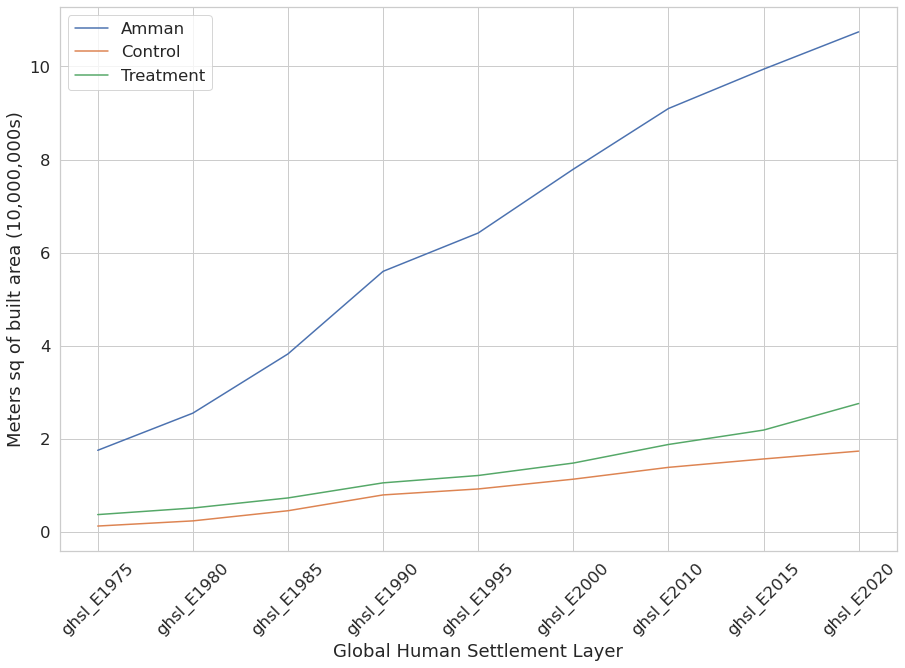

In [198]:
resG['CAT'] = inH['CAT']
plotG = pd.DataFrame(resG.groupby('CAT').sum())
plotG = pd.DataFrame(plotG.drop(['ghsl_P2030LIN', 'ghsl_P2025LIN', "AMMAN","TREAT","CONTROL"], axis=1))
plotG = plotG.drop("")

plt.rcParams["figure.figsize"] = (15,10)

plt.plot(plotG.transpose()/10000000, label=list(plotG.index))
plt.legend(loc="upper left")
plt.xticks(rotation = 45)
plt.ylabel("Meters sq of built area (10,000,000s)")
plt.xlabel("Global Human Settlement Layer")
plt.show()

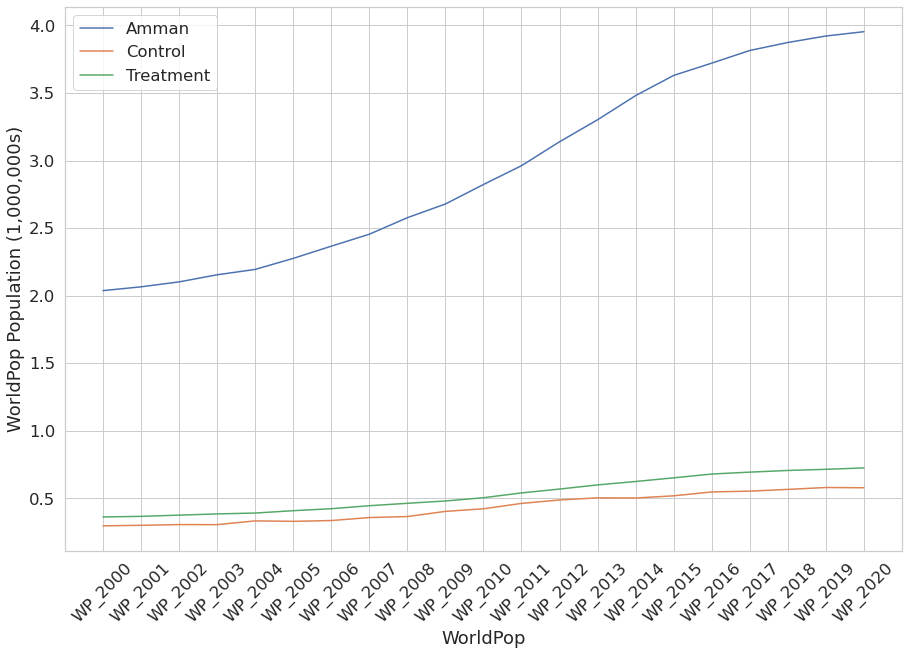

In [197]:
resP['CAT'] = inH['CAT']
plotG = pd.DataFrame(resP.groupby('CAT').sum())
plotG = plotG.drop("")
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(plotG.transpose()/1000000, label=list(plotG.index))
plt.legend(loc="upper left")
plt.xticks(rotation = 45)
plt.ylabel("WorldPop Population (1,000,000s)")
plt.xlabel("WorldPop")
plt.show()

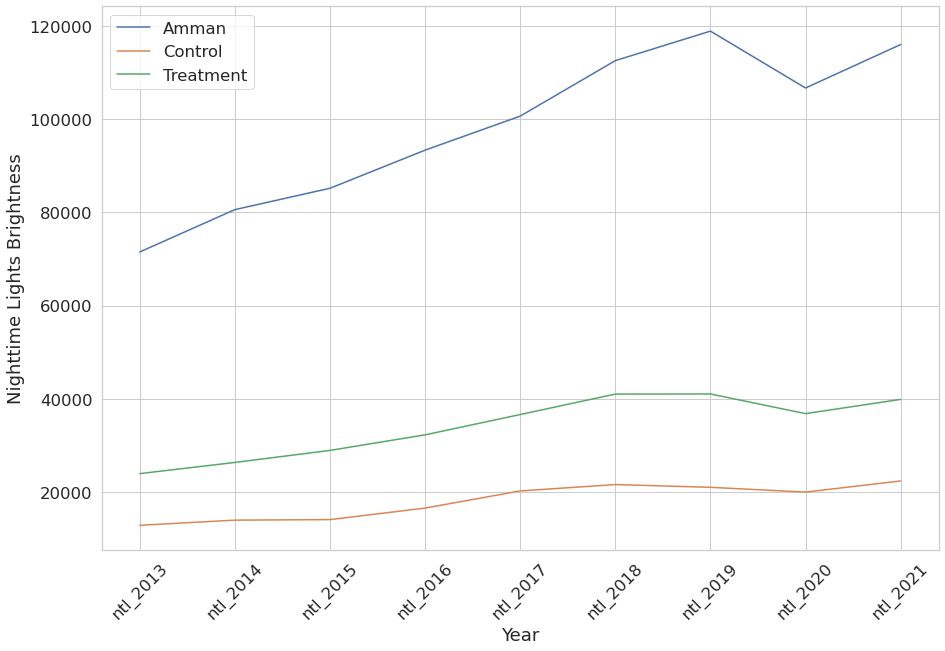

In [196]:
resH['CAT'] = inH['CAT']
plotG = pd.DataFrame(resH.groupby('CAT').sum())
plotG = plotG.drop("")
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(plotG.transpose(), label=list(plotG.index))
plt.legend(loc="upper left")
plt.xticks(rotation = 45)
plt.ylabel("Nighttime Lights Brightness")
plt.xlabel("Year")
plt.show()

## Generate per capita maps of NTL and GHSL

In [192]:
list(plotG.index)

['Amman', 'Control', 'Treatment']

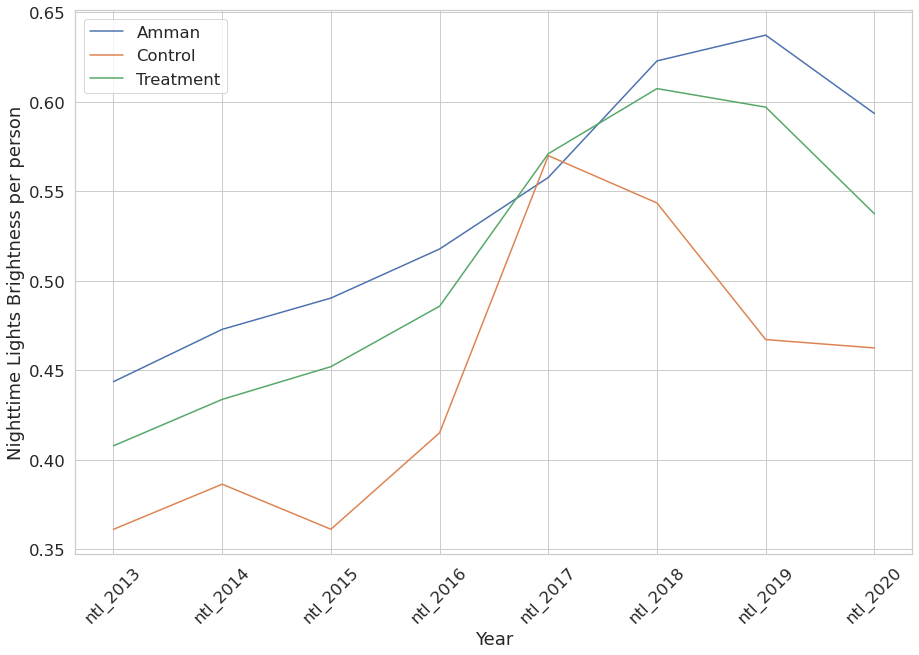

In [193]:
ntlD = resH.drop(['geometry'], axis=1).copy()
for col in ntlD.columns:
    if col.startswith('ntl'):
        year = col.split("_")[-1]
        try:
            curP = resP.loc[:,[year in x for x in resP.columns]].iloc[:,0]
            curN = ntlD.loc[:,col].values
            ntlD[col] = [x[1]/x[0] for x in zip(curP, curN)]    
        except:
            ntlD.drop([col], axis=1, inplace=True)

            
plotG = pd.DataFrame(ntlD.groupby('CAT').sum())
plotG = plotG.drop("")
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(plotG.transpose(), label=list(plotG.index))
plt.legend(loc="upper left")
plt.xticks(rotation = 45)
plt.ylabel("Nighttime Lights Brightness per person")
plt.xlabel("Year")
plt.show()

In [187]:
ntlG = resG.drop(['geometry','AMMAN','TREAT','CONTROL'], axis=1).copy()
for col in ntlG.columns:
    if col.startswith('ghsl'):
        year = col[-4:]
        try:
            curP = resP.loc[:,[year in x for x in resP.columns]].iloc[:,0]
            curN = ntlG.loc[:,col].values
            ntlG[col] = [x[1]/x[0] for x in zip(curP, curN)]    
        except:
            ntlG.drop([col], axis=1, inplace=True)


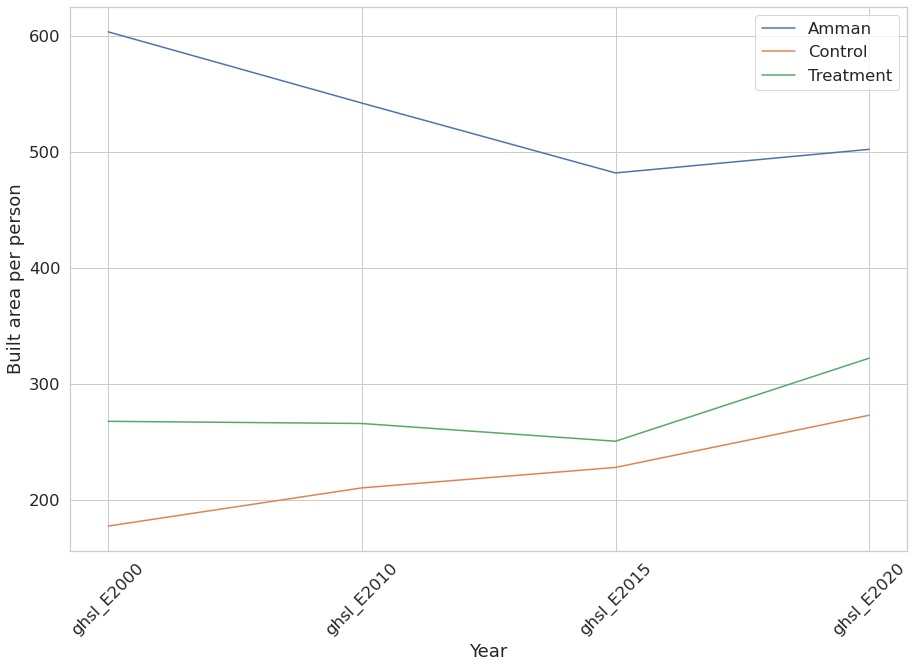

In [195]:
plotG = pd.DataFrame(ntlG.groupby('CAT').sum())
plotG = plotG.drop("")
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(plotG.transpose(), label=list(plotG.index))
plt.legend(loc="upper right")
plt.xticks(rotation = 45)
plt.ylabel("Built area per person")
plt.xlabel("Year")
plt.show()